In [173]:
!pip install plotly --quiet
!pip install ipywidgets --quiet

In [162]:
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from IPython.display import HTML

In [165]:
pio.renderers.default = 'iframe'

In [10]:
project_dirpath = Path('/')/'tf'/'workspace'/'deformation-prediction-multi-environment'
data_dirpath = project_dirpath/'data'/'preprocessed'/'shape'/'binarized'

location = '511'
shape_filepath = data_dirpath/f'shape_{location}.npy'
shapes = np.load(shape_filepath)
shapes.shape

(12000, 28, 28)

In [15]:
shapes_flattened = shapes.reshape(shapes.shape[0], -1)

TODO: 別のrandom_stateも試す

# PCA

In [77]:
# Apply PCA to reduce dimensions (optional but helps t-SNE perform better)
pca = PCA(n_components=0.9)
shapes_pca = pca.fit_transform(shapes_flattened)

In [113]:
shapes_pca.shape

(12000, 33)

In [104]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(shapes_pca)

/home/kodera/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


/home/kodera/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


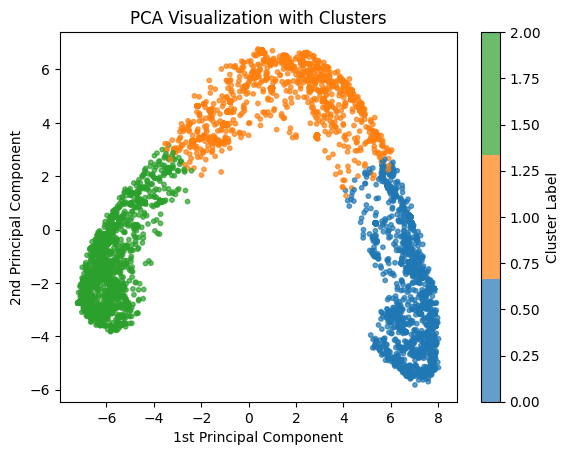

In [117]:
# Perform K-Means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(shapes_pca)

cmap = mcolors.ListedColormap(plt.cm.tab10.colors[:n_clusters])

# Visualize clusters
plt.scatter(shapes_pca[:, 0], shapes_pca[:, 1], c=labels, cmap=cmap, alpha=0.7, s=10)
plt.title("PCA Visualization with Clusters")
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")
plt.colorbar(label="Cluster Label")
plt.show()

In [172]:
# DataFrameの作成
df = pd.DataFrame({
    'Index': range(len(shapes_pca)),
    'PC1': shapes_pca[:, 0],  # 第1主成分
    'PC2': shapes_pca[:, 1],  # 第2主成分
    'PC3': shapes_pca[:, 2],  # 第3主成分
    'Cluster': labels          # クラスタラベル
})

# Plotlyで3D散布図を作成
fig = px.scatter_3d(
    df,
    x='PC1', y='PC2', z='PC3',  # 軸
    color='Cluster',            # クラスタラベルで色分け
    hover_data = ['Index'],
    title="3D PCA Visualization with Clusters",
    labels={"PC1": "1st Principal Component", "PC2": "2nd Principal Component", "PC3": "3rd Principal Component"},
    opacity=0.6                 # 透明度
)

# 表示
fig.update_traces(marker=dict(size=3))
fig.show()

In [138]:
def visualize_clusters(images, labels, num_samples=5):
    """
    クラスターごとの画像をプロットする。
    images: 画像データ (形状: (N, 28, 28))
    labels: クラスターラベル (長さ N)
    num_samples: 各クラスターから可視化する画像の数
    """
    unique_labels = np.unique(labels)
    num_clusters = len(unique_labels)
    plt.figure(figsize=(num_samples * 2, num_clusters * 2))
    
    for cluster_id in unique_labels:
        # 該当クラスターの画像インデックスを取得
        cluster_indices = np.where(labels == cluster_id)[0]
        
        # サンプリング
        sampled_indices = np.random.choice(cluster_indices, size=min(num_samples, len(cluster_indices)), replace=False)
        
        for i, img_idx in enumerate(sampled_indices):
            plt.subplot(num_clusters, num_samples, cluster_id * num_samples + i + 1)
            plt.imshow(images[img_idx], cmap='gray')
            plt.axis('off')
            plt.title(f"Cluster {cluster_id}")
    
    plt.tight_layout()
    plt.show()

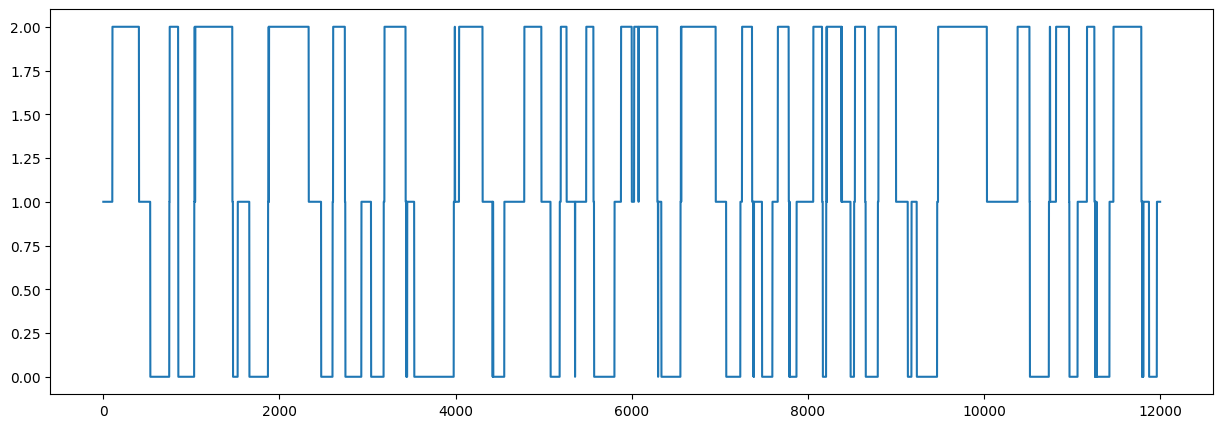

In [145]:
plt.figure(figsize=(15, 5))
plt.plot(labels)
plt.show()

In [179]:
# それぞれのサンプル数をみる
counts = {value: np.sum(labels == value) for value in set(labels)}
print(counts)

{0: 3671, 1: 3231, 2: 5098}


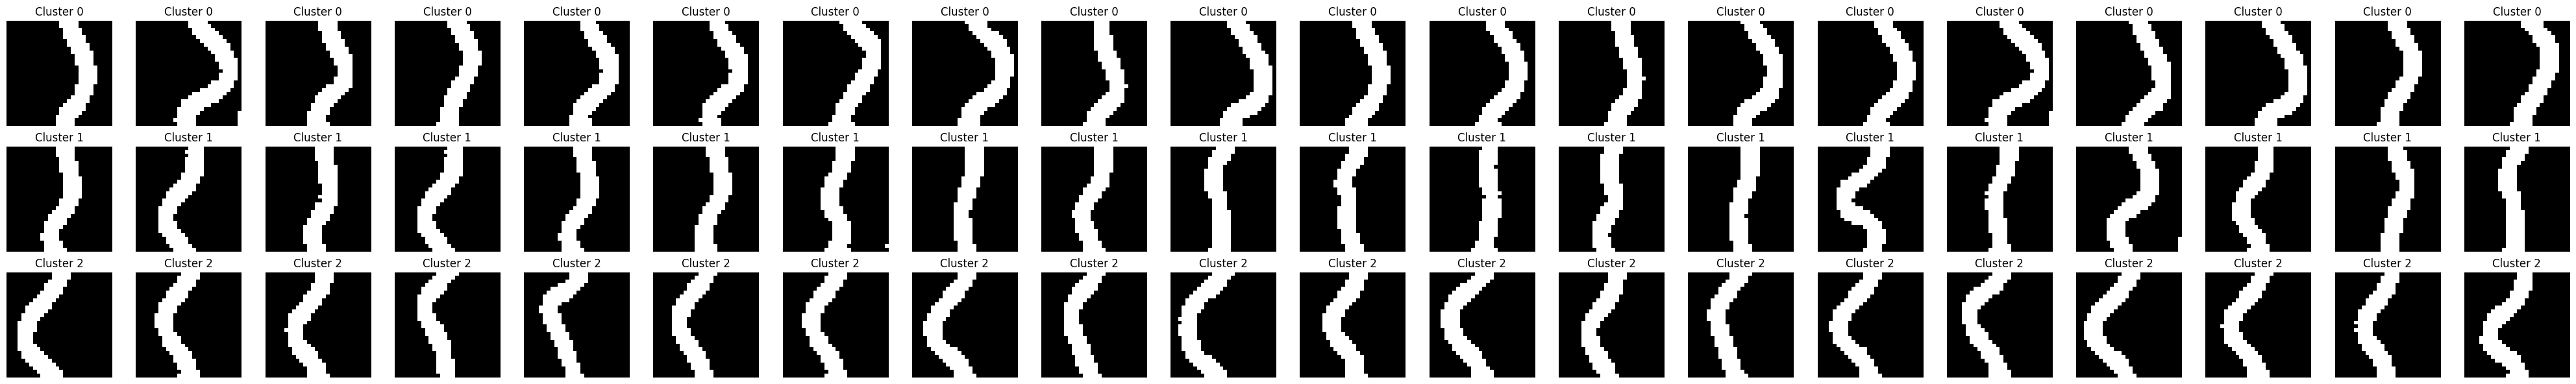

In [141]:
visualize_clusters(shapes, labels, num_samples=20)

# t-SNE

In [78]:
# Apply t-SNE to map data into 2D
tsne = TSNE(n_components=2, random_state=44)
shapes_tsne = tsne.fit_transform(shapes_pca)

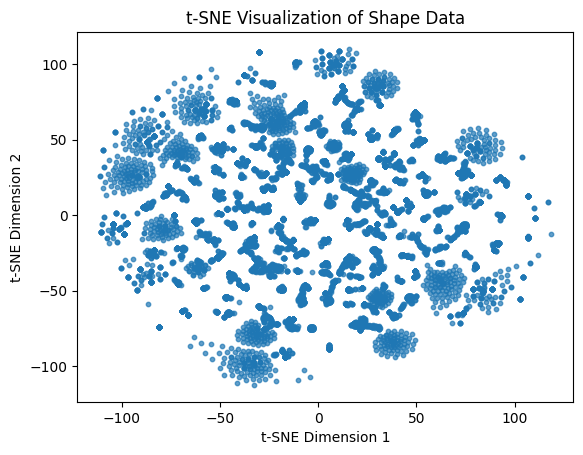

In [79]:
plt.scatter(shapes_tsne[:, 0], shapes_tsne[:, 1], alpha=0.7, s=10)
plt.title("t-SNE Visualization of Shape Data")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

TODO: UMAPも試す

PCAの後にk-meansをやる

やりたいこと：クラスタごとに精度を観察したい  
期待としては、3クラスタ（左曲がり、右曲がり、まっすぐ）に分かれてほしい 

x軸方向の最大値をみることで、左曲がりか右曲がりかを定量化できる

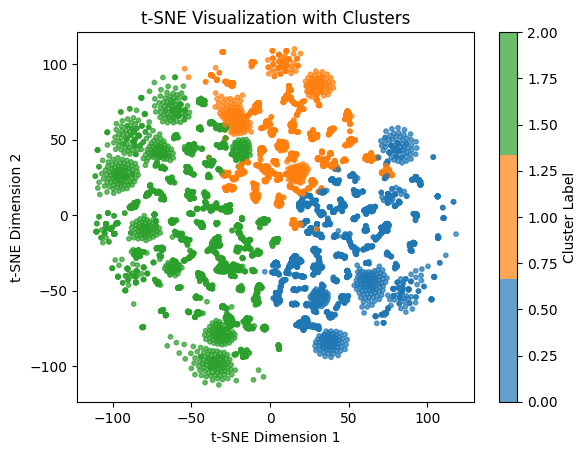

In [137]:
cmap = mcolors.ListedColormap(plt.cm.tab10.colors[:n_clusters])

# Visualize clusters
plt.scatter(shapes_tsne[:, 0], shapes_tsne[:, 1], c=labels, cmap=cmap, alpha=0.7, s=10)
plt.title("t-SNE Visualization with Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()

# UMAP

In [99]:
import umap.umap_ as umap

In [97]:
# UMAPでさらに次元削減
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
shapes_umap = umap_reducer.fit_transform(shapes_pca)

/home/kodera/.local/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


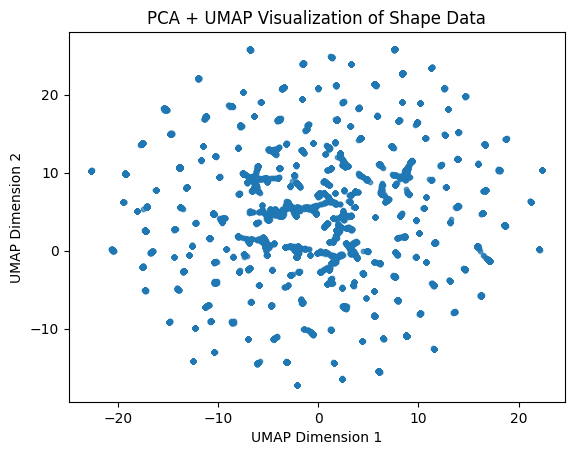

In [98]:
plt.scatter(shapes_umap[:, 0], shapes_umap[:, 1], alpha=0.7, s=10)
plt.title("PCA + UMAP Visualization of Shape Data")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

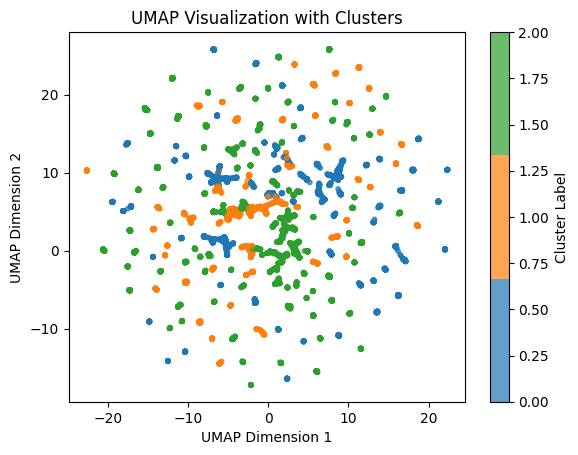

In [174]:
# Visualize clusters
plt.scatter(shapes_umap[:, 0], shapes_umap[:, 1], c=labels, cmap=cmap, alpha=0.7, s=10)
plt.title("UMAP Visualization with Clusters")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.colorbar(label="Cluster Label")
plt.show()